# Static -  Music Dataset

# Data Preprocessing

### Since the data set files are too large we could not download them through Gdown. If you already have the data set, define the path to the folder under the folder_path variable

In [ ]:
folder_path = 'fma_metadata'

In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import os
import dotenv
import pydot
import requests
import numpy as np
import pandas as pd
import ctypes
import shutil
import multiprocessing
import multiprocessing.sharedctypes as sharedctypes
import os.path
import ast
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.ensemble import IsolationForest

In [2]:
# Number of samples per 30s audio clip.
# TODO: fix dataset to be constant.
NB_AUDIO_SAMPLES = 1321967
SAMPLING_RATE = 44100

# Load the environment from the .env file.
dotenv.load_dotenv(dotenv.find_dotenv())


class FreeMusicArchive:

    BASE_URL = 'https://freemusicarchive.org/api/get/'

    def __init__(self, api_key):
        self.api_key = api_key

    def get_recent_tracks(self):
        URL = 'https://freemusicarchive.org/recent.json'
        r = requests.get(URL)
        r.raise_for_status()
        tracks = []
        artists = []
        date_created = []
        for track in r.json()['aTracks']:
            tracks.append(track['track_id'])
            artists.append(track['artist_name'])
            date_created.append(track['track_date_created'])
        return tracks, artists, date_created

    def _get_data(self, dataset, fma_id, fields=None):
        url = self.BASE_URL + dataset + 's.json?'
        url += dataset + '_id=' + str(fma_id) + '&api_key=' + self.api_key
        # print(url)
        r = requests.get(url)
        r.raise_for_status()
        if r.json()['errors']:
            raise Exception(r.json()['errors'])
        data = r.json()['dataset'][0]
        r_id = data[dataset + '_id']
        if r_id != str(fma_id):
            raise Exception('The received id {} does not correspond to'
                            'the requested one {}'.format(r_id, fma_id))
        if fields is None:
            return data
        if type(fields) is list:
            ret = {}
            for field in fields:
                ret[field] = data[field]
            return ret
        else:
            return data[fields]

    def get_track(self, track_id, fields=None):
        return self._get_data('track', track_id, fields)

    def get_album(self, album_id, fields=None):
        return self._get_data('album', album_id, fields)

    def get_artist(self, artist_id, fields=None):
        return self._get_data('artist', artist_id, fields)

    def get_all(self, dataset, id_range):
        index = dataset + '_id'

        id_ = 2 if dataset == 'track' else 1
        row = self._get_data(dataset, id_)
        df = pd.DataFrame(columns=row.keys())
        df.set_index(index, inplace=True)

        not_found_ids = []

        for id_ in id_range:
            try:
                row = self._get_data(dataset, id_)
            except:
                not_found_ids.append(id_)
                continue
            row.pop(index)
            df = df.append(pd.Series(row, name=id_))

        return df, not_found_ids

    def download_track(self, track_file, path):
        url = 'https://files.freemusicarchive.org/' + track_file
        r = requests.get(url, stream=True)
        r.raise_for_status()
        with open(path, 'wb') as f:
            shutil.copyfileobj(r.raw, f)

    def get_track_genres(self, track_id):
        genres = self.get_track(track_id, 'track_genres')
        genre_ids = []
        genre_titles = []
        for genre in genres:
            genre_ids.append(genre['genre_id'])
            genre_titles.append(genre['genre_title'])
        return genre_ids, genre_titles

    def get_all_genres(self):
        df = pd.DataFrame(columns=['genre_parent_id', 'genre_title',
                                   'genre_handle', 'genre_color'])
        df.index.rename('genre_id', inplace=True)

        page = 1
        while True:
            url = self.BASE_URL + 'genres.json?limit=50'
            url += '&page={}&api_key={}'.format(page, self.api_key)
            r = requests.get(url)
            for genre in r.json()['dataset']:
                genre_id = int(genre.pop(df.index.name))
                df.loc[genre_id] = genre
            assert (r.json()['page'] == str(page))
            page += 1
            if page > r.json()['total_pages']:
                break

        return df


class Genres:

    def __init__(self, genres_df):
        self.df = genres_df

    def create_tree(self, roots, depth=None):

        if type(roots) is not list:
            roots = [roots]
        graph = pydot.Dot(graph_type='digraph', strict=True)

        def create_node(genre_id):
            title = self.df.at[genre_id, 'title']
            ntracks = self.df.at[genre_id, '#tracks']
            # name = self.df.at[genre_id, 'title'] + '\n' + str(genre_id)
            name = '"{}\n{} / {}"'.format(title, genre_id, ntracks)
            return pydot.Node(name)

        def create_tree(root_id, node_p, depth):
            if depth == 0:
                return
            children = self.df[self.df['parent'] == root_id]
            for child in children.iterrows():
                genre_id = child[0]
                node_c = create_node(genre_id)
                graph.add_edge(pydot.Edge(node_p, node_c))
                create_tree(genre_id, node_c,
                            depth-1 if depth is not None else None)

        for root in roots:
            node_p = create_node(root)
            graph.add_node(node_p)
            create_tree(root, node_p, depth)

        return graph

    def find_roots(self):
        roots = []
        for gid, row in self.df.iterrows():
            parent = row['parent']
            title = row['title']
            if parent == 0:
                roots.append(gid)
            elif parent not in self.df.index:
                msg = '{} ({}) has parent {} which is missing'.format(
                        gid, title, parent)
                raise RuntimeError(msg)
        return roots


def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks


def get_audio_path(audio_dir, track_id):
    """
    Return the path to the mp3 given the directory where the audio is stored
    and the track ID.
    Examples
    --------
    >>> import utils
    >>> AUDIO_DIR = os.environ.get('AUDIO_DIR')
    >>> utils.get_audio_path(AUDIO_DIR, 2)
    '../data/fma_small/000/000002.mp3'
    """
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')


class Loader:
    def load(self, filepath):
        raise NotImplementedError()


class RawAudioLoader(Loader):
    def __init__(self, sampling_rate=SAMPLING_RATE):
        self.sampling_rate = sampling_rate
        self.shape = (NB_AUDIO_SAMPLES * sampling_rate // SAMPLING_RATE, )

    def load(self, filepath):
        return self._load(filepath)[:self.shape[0]]


class LibrosaLoader(RawAudioLoader):
    def _load(self, filepath):
        import librosa
        sr = self.sampling_rate if self.sampling_rate != SAMPLING_RATE else None
        # kaiser_fast is 3x faster than kaiser_best
        # x, sr = librosa.load(filepath, sr=sr, res_type='kaiser_fast')
        x, sr = librosa.load(filepath, sr=sr)
        return x


class AudioreadLoader(RawAudioLoader):
    def _load(self, filepath):
        import audioread
        a = audioread.audio_open(filepath)
        a.read_data()


class PydubLoader(RawAudioLoader):
    def _load(self, filepath):
        from pydub import AudioSegment
        song = AudioSegment.from_file(filepath)
        song = song.set_channels(1)
        x = song.get_array_of_samples()
        # print(filepath) if song.channels != 2 else None
        return np.array(x)


class FfmpegLoader(RawAudioLoader):
    def _load(self, filepath):
        """Fastest and less CPU intensive loading method."""
        import subprocess as sp
        command = ['ffmpeg',
                   '-i', filepath,
                   '-f', 's16le',
                   '-acodec', 'pcm_s16le',
                   '-ac', '1']  # channels: 2 for stereo, 1 for mono
        if self.sampling_rate != SAMPLING_RATE:
            command.extend(['-ar', str(self.sampling_rate)])
        command.append('-')
        # 30s at 44.1 kHz ~= 1.3e6
        proc = sp.run(command, stdout=sp.PIPE, bufsize=10**7, stderr=sp.DEVNULL, check=True)

        return np.fromstring(proc.stdout, dtype="int16")


def build_sample_loader(audio_dir, Y, loader):

    class SampleLoader:

        def __init__(self, tids, batch_size=4):
            self.lock1 = multiprocessing.Lock()
            self.lock2 = multiprocessing.Lock()
            self.batch_foremost = sharedctypes.RawValue(ctypes.c_int, 0)
            self.batch_rearmost = sharedctypes.RawValue(ctypes.c_int, -1)
            self.condition = multiprocessing.Condition(lock=self.lock2)

            data = sharedctypes.RawArray(ctypes.c_int, tids.data)
            self.tids = np.ctypeslib.as_array(data)

            self.batch_size = batch_size
            self.loader = loader
            self.X = np.empty((self.batch_size, *loader.shape))
            self.Y = np.empty((self.batch_size, Y.shape[1]), dtype=np.int)

        def __iter__(self):
            return self

        def __next__(self):

            with self.lock1:
                if self.batch_foremost.value == 0:
                    np.random.shuffle(self.tids)

                batch_current = self.batch_foremost.value
                if self.batch_foremost.value + self.batch_size < self.tids.size:
                    batch_size = self.batch_size
                    self.batch_foremost.value += self.batch_size
                else:
                    batch_size = self.tids.size - self.batch_foremost.value
                    self.batch_foremost.value = 0

                # print(self.tids, self.batch_foremost.value, batch_current, self.tids[batch_current], batch_size)
                # print('queue', self.tids[batch_current], batch_size)
                tids = np.array(self.tids[batch_current:batch_current+batch_size])

            batch_size = 0
            for tid in tids:
                try:
                    audio_path = get_audio_path(audio_dir, tid)
                    self.X[batch_size] = self.loader.load(audio_path)
                    self.Y[batch_size] = Y.loc[tid]
                    batch_size += 1
                except Exception as e:
                    print("\nIgnoring " + audio_path +" (error: " + str(e) +").")

            with self.lock2:
                while (batch_current - self.batch_rearmost.value) % self.tids.size > self.batch_size:
                    # print('wait', indices[0], batch_current, self.batch_rearmost.value)
                    self.condition.wait()
                self.condition.notify_all()
                # print('yield', indices[0], batch_current, self.batch_rearmost.value)
                self.batch_rearmost.value = batch_current

                return self.X[:batch_size], self.Y[:batch_size]

    return SampleLoader

In [3]:
# Directory where mp3 are stored.
AUDIO_DIR = os.environ.get('AUDIO_DIR')

# Load metadata and features.
tracks = load(f'{folder_path}/tracks.csv')
genres = load(f'{folder_path}/genres.csv')
features = load(f'{folder_path}/features.csv')
echonest = load(f'{folder_path}/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [4]:
tracks.head()

album                                                          \
         comments        date_created date_released engineer favorites id   
track_id                                                                    
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
3               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4  6   
20              0 2008-11-26 01:45:05    2009-01-06      NaN         2  4   

                                                                           \
                                        information listens producer tags   
track_id                                                                    
2                                           <p></p>    6073      NaN   []   
3                                           <p></p>    6073      NaN   []   
5                                           <p></p>    6073      NaN   []   
10                                              NaN   47632      NaN   []   
20        <p> "spiritual songs" from Nicky Cook</p>    2710      NaN   []   

          ...       track                         \
          ... information interest language_code   
track_id  ...                                      
2         ...         NaN     4656            en   
3         ...         NaN     1470            en   
5         ...         NaN     1933            en   
10        ...         NaN    54881            en   
20        ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

In [5]:
genres.head()

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5


In [6]:
features.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
20         -0.289294 -0.816410  0.043851 -0.804761  ...  0.095003  0.022492   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
20          0.021355  16.669037  0.469727  0.047225  0.040039  0.000977   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
3           1.716724  0.069330  
5           2.193303  0.044861  
10          3.542325  0.040800  
20          3.189831  0.030993  

[5 rows x 518 columns]

In [7]:
echonest.head()

echonest                                                    \
         audio_features                                                     
           acousticness danceability    energy instrumentalness  liveness   
track_id                                                                    
2              0.416675     0.675894  0.634476         0.010628  0.177647   
3              0.374408     0.528643  0.817461         0.001851  0.105880   
5              0.043567     0.745566  0.701470         0.000697  0.373143   
10             0.951670     0.658179  0.924525         0.965427  0.115474   
134            0.452217     0.513238  0.560410         0.019443  0.096567   

                                                                        ...  \
                                           metadata                     ...   
         speechiness    tempo   valence  album_date         album_name  ...   
track_id                                                                ...   
2           0.159310  165.922  0.576661         NaN                NaN  ...   
3           0.461818  126.957  0.269240         NaN                NaN  ...   
5           0.124595  100.260  0.621661         NaN                NaN  ...   
10          0.032985  111.562  0.963590  2008-03-11  Constant Hitmaker  ...   
134         0.525519  114.290  0.894072         NaN                NaN  ...   

                                                                              \
         temporal_features                                                     
                       214        215       216       217       218      219   
track_id                                                                       
2                -1.992303   6.805694  0.233070  0.192880  0.027455  0.06408   
3                -1.582331   8.889308  0.258464  0.220905  0.081368  0.06413   
5                -2.288358  11.527109  0.256821  0.237820  0.060122  0.06014   
10               -3.662988  21.508228  0.283352  0.267070  0.125704  0.08082   
134              -1.452696   2.356398  0.234686  0.199550  0.149332  0.06440   

                                                     
                                                     
               220       221        222         223  
track_id                                             
2          3.67696   3.61288  13.316690  262.929749  
3          6.08277   6.01864  16.673548  325.581085  
5          5.92649   5.86635  16.013849  356.755737  
10         8.41401   8.33319  21.317064  483.403809  
134       11.26707  11.20267  26.454180  751.147705  

[5 rows x 249 columns]

In [8]:
small = tracks[tracks['set', 'subset'] <= 'small']
medium = tracks[tracks['set', 'subset'] <= 'medium']
columns = ['mfcc', 'chroma_cens', 'tonnetz', 'spectral_contrast']
columns.append(['spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff'])
columns.append(['rmse', 'zcr'])
small = tracks['set', 'subset'] <= 'small'
genre1 = tracks['track', 'genre_top'] == 'Instrumental'
genre2 = tracks['track', 'genre_top'] == 'Hip-Hop'

# Without PCA

In [9]:
X = features.loc[small & (genre1 | genre2), 'mfcc']
y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]

In [10]:
set(y)

{'Hip-Hop', 'Instrumental'}

In [11]:
y = skl.preprocessing.LabelEncoder().fit_transform(y)

In [12]:
X.shape, y.shape

((2000, 140), (2000,))

In [13]:
cluster_count = len(set(y))
cluster_count

2

# Kmeans without PCA

In [25]:
X = X.values

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# Apply the KMeans algorithm to the  data
kmeans = KMeans(n_clusters=2, random_state=42)
labels_kmeans = kmeans.fit_predict(X)
silhouette_score(X, labels_kmeans)

0.3805621538620501

In [27]:
# Get the cluster labels and centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [28]:
set(labels_kmeans)

{0, 1}

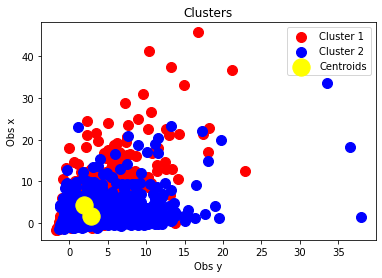

In [29]:
plt.scatter(X[labels_kmeans == 0, 0], X[labels_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[labels_kmeans == 1, 0], X[labels_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')

plt.scatter(centers[:, 0], centers[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters')
plt.xlabel('Obs y')
plt.ylabel('Obs x')
plt.legend()
plt.show()

# EM without PCA

In [30]:
from sklearn.mixture import GaussianMixture
# Create a Gaussian Mixture model with 5 components
gmm = GaussianMixture(n_components=cluster_count, random_state=0)

# Fit the model to the time series data
gmm.fit(X)

# Get the cluster labels for each time series
labels_em = gmm.predict(X)

# Get the means and covariances of the components
means = gmm.means_
covariances = gmm.covariances_

In [31]:
silhouette_score(X, labels_em)

0.3439771342861442

# Hierarchical Clustering (before PCA)


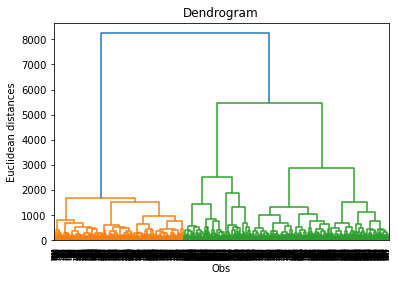

In [33]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Obs')
plt.ylabel('Euclidean distances')
plt.show()

In [34]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = cluster_count, affinity = 'euclidean', linkage = 'ward')
labels_hc = hc.fit_predict(X)

In [35]:
silhouette_score(X, labels_hc)

0.27950765829808083

# DBSCAN (before PCA)

In [82]:
from sklearn.cluster import DBSCAN
# eps is epsilon the starting point, and min_samples is the minimum points that must
# exist for cluster to be formed
dbscan = DBSCAN(eps=0.01, min_samples=2).fit(X)
labels_db = dbscan.labels_

# Print the data and the number of clusters
print(f'The number of clusters is: {len(set(labels_db))}')

The number of clusters is: 7


In [83]:
silhouette_score(X, labels_db)

-0.19854322189209336

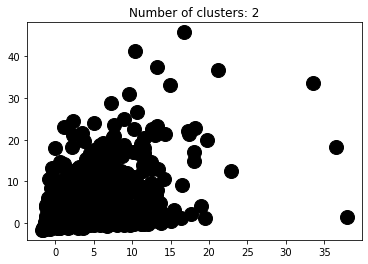

In [84]:
import numpy as np
unique_labels = set(labels_db)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1] # noise points in black
    class_member_mask = (labels_db == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)
    plt.title('Number of clusters: {}'.format(2))

plt.show()

# Anomaly detection using Isolation Forest

In [86]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.1)
isolation_forest.fit(X)
inliers_X = X[isolation_forest.predict(X) == 1]
inliers_y = y[isolation_forest.predict(X) == 1]
inliers_X.shape

(1800, 140)

# Kmeans without Anomalies

In [87]:
# Apply the KMeans algorithm to the  data
km = KMeans(n_clusters = 2, random_state = 0)
labels_kmeans = km.fit_predict(inliers_X)

In [88]:
silhouette_score(inliers_X, labels_kmeans)

0.38836850386339267

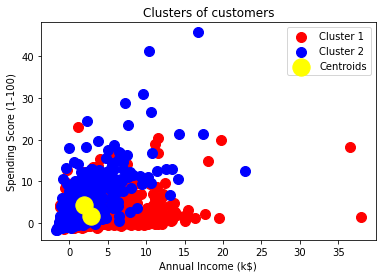

In [89]:
plt.scatter(inliers_X[labels_kmeans == 0, 0], inliers_X[labels_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(inliers_X[labels_kmeans == 1, 0], inliers_X[labels_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')

plt.scatter(centers[:, 0], centers[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

# EM without Anomalies

In [90]:
from sklearn.mixture import GaussianMixture
# Create a Gaussian Mixture model with 5 components
gmm = GaussianMixture(n_components=2, random_state=0)

# Fit the model to the time series data
gmm.fit(inliers_X)

# Get the cluster labels for each time series
labels_em = gmm.predict(inliers_X)

# Get the means and covariances of the components
means = gmm.means_
covariances = gmm.covariances_

In [91]:
silhouette_score(inliers_X, labels_em)

0.3578798416255373

# Hierarchical Clustering (without Anomalies)

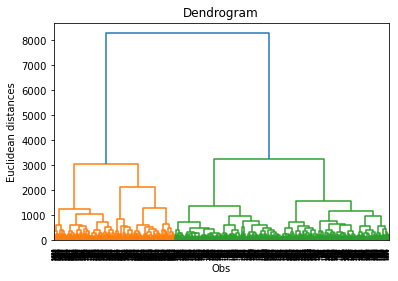

In [92]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(inliers_X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Obs')
plt.ylabel('Euclidean distances')
plt.show()

In [93]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
labels_hc = hc.fit_predict(inliers_X)

In [94]:
silhouette_score(inliers_X, labels_hc)

0.3784295215500279

# DBSCAN (without Anomalies)

In [114]:
from sklearn.cluster import DBSCAN
# eps is epsilon the starting point, and min_samples is the minimum points that must
# exist for cluster to be formed
dbscan = DBSCAN(eps=0.000001, min_samples=2).fit(inliers_X)
labels = dbscan.labels_

# Print the data and the number of clusters
print(f'The number of clusters is: {len(set(labels))}')

The number of clusters is: 4


In [115]:
silhouette_score(inliers_X, labels)

-0.1415728841384331

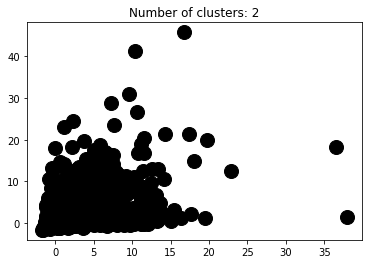

In [116]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1] # noise points in black
    class_member_mask = (labels == k)
    xy = inliers_X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)
    plt.title('Number of clusters: {}'.format(2))

plt.show()

# After PCA

((2000, 2), (2000,))

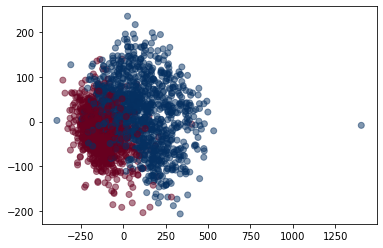

In [118]:
X = features.loc[small & (genre1 | genre2), 'mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X.values)

y = tracks.loc[small & (genre1 | genre2), ('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math
set(y)

{0, 1}

In [120]:
cluster_count = len(set(y))
cluster_count

2

# Kmeans with PCA

In [121]:
# Apply the KMeans algorithm to the  data
km = KMeans(n_clusters = cluster_count, random_state = 0)
labels_kmeans = km.fit_predict(X)

In [122]:
silhouette_score(X, labels_kmeans)

0.5212246503350347

In [123]:
# Get the cluster labels and centers
labels = km.labels_
centers = km.cluster_centers_

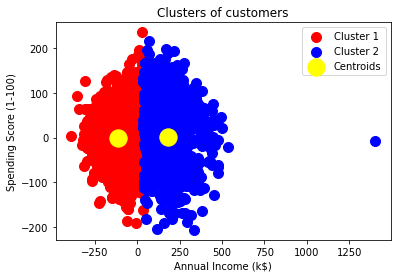

In [124]:
plt.scatter(X[labels_kmeans == 0, 0], X[labels_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')
plt.scatter(X[labels_kmeans == 1, 0], X[labels_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')

plt.scatter(centers[:, 0], centers[:, 1], s = 300, c = 'yellow', label = 'Centroids')
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.show()

# EM with PCA


In [125]:
from sklearn.mixture import GaussianMixture
# Create a Gaussian Mixture model with 5 components
gmm = GaussianMixture(n_components=cluster_count, random_state=0)

# Fit the model to the time series data
gmm.fit(X)

# Get the cluster labels for each time series
labels_em = gmm.predict(X)

# Get the means and covariances of the components
means = gmm.means_
covariances = gmm.covariances_

In [126]:
silhouette_score(X, labels_em)

0.4787581521380454

# EM with alternating maximization (after PCA)

In [127]:
# Initialize cluster centers randomly
centers = np.random.randn(cluster_count, X.shape[1])

# Run the Expectation-Maximization algorithm with alternating maximization
for i in range(10):
    # Expectation step
    dist = np.linalg.norm(X[:, np.newaxis, :] - centers, axis=2)
    membership = np.argmin(dist, axis=1)
    
    # Maximization step
    for j in range(cluster_count):
        centers[j] = np.mean(X[membership == j], axis=0)

# Use KMeans to verify results
gmm_am = GaussianMixture(n_components=cluster_count, random_state=0)
gmm_am.fit(X)
labels_am = gmm.predict(X)

In [128]:
# without alt max to verify results
silhouette_score(X, labels_am)

0.4787581521380454

# silhouette score for the EM model with the Alternate Maximazation

In [129]:
silhouette_score(X, membership)

0.5210885065642795

# Hierarchical Clustering with PCA

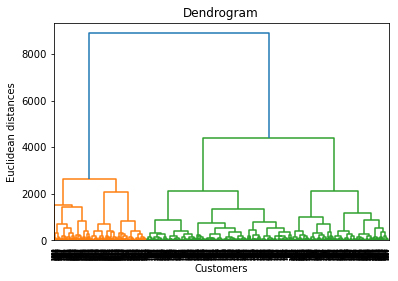

In [130]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [131]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = cluster_count, affinity = 'euclidean', linkage = 'ward')
labels_hc = hc.fit_predict(X)

In [132]:
silhouette_score(X, labels_hc)

0.5062027276875516

# DBSCAN with PCA

In [144]:
from sklearn.cluster import DBSCAN
# eps is epsilon the starting point, and min_samples is the minimum points that must
# exist for cluster to be formed
dbscan = DBSCAN(eps=0.01, min_samples=2).fit(X)
labels_db = dbscan.labels_

# Print the data and the number of clusters
print(f'The number of clusters is: {len(set(labels_db))}')

The number of clusters is: 7


In [140]:
silhouette_score(X, labels_db)

-0.34645923765090697

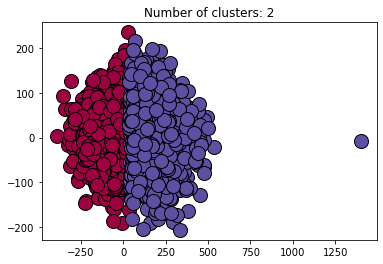

In [141]:
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1] # noise points in black
    class_member_mask = (labels == k)
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)
    plt.title('Number of clusters: {}'.format(2))

plt.show()